# Task 1: Data Preprocessing and Exploratory Data Analysis (EDA)

This notebook covers:
- Data extraction using yfinance
- Data cleaning and preprocessing
- Exploratory data analysis
- Stationarity testing
- Risk metrics calculation


In [4]:
import yfinance as yf
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
from pathlib import Path
import sys

# Add src directory to path for utility functions
# Note: In notebooks, __file__ may not work, so we use an absolute path
project_root = Path().resolve().parent if Path().resolve().name == "notebooks" else Path().resolve()
sys.path.append(str(project_root / "src"))
from data_utils import (
    download_data, extract_prices, compute_returns, 
    detect_outliers, plot_prices, plot_returns, plot_rolling_statistics
)

plt.style.use("seaborn-v0_8")

In [6]:
tickers = ["TSLA", "BND", "SPY"]

# Download data with error handling
try:
    data = download_data(
        tickers=tickers,
        start="2015-01-01",
        end="2026-01-15",
        group_by="ticker",
        auto_adjust=True,
        progress=False,
        threads=False
    )
    print(f"Successfully downloaded data for {tickers}")
except ValueError as e:
    print(f"Error downloading data: {e}")
    raise


c:\Users\teshi\Desktop\Projects\KAIM\portfolio-optimization\venv\Lib\site-packages\yfinance\scrapers\history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
c:\Users\teshi\Desktop\Projects\KAIM\portfolio-optimization\venv\Lib\site-packages\yfinance\scrapers\history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
c:\Users\teshi\Desktop\Projects\KAIM\portfolio-optimization\venv\Lib\site-packages\yfinance\scrapers\history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()


## Data Overview

We extract historical daily market data for Tesla (TSLA), 
Vanguard Total Bond Market ETF (BND), and S&P 500 ETF (SPY).


In [7]:
prices = pd.DataFrame({
    "TSLA": data["TSLA"]["Close"],
    "BND": data["BND"]["Close"],
    "SPY": data["SPY"]["Close"]
})


In [ ]:
# Plot prices over time using utility function
plot_prices(prices, title="Asset Prices Over Time", figsize=(12, 5))

In [ ]:
# Create data/processed directory if it doesn't exist
import os
os.makedirs("data/processed", exist_ok=True)

# Persist cleaned dataset to data/processed/
prices.to_csv("data/processed/prices_cleaned.csv")
prices.to_parquet("data/processed/prices_cleaned.parquet")
print("Cleaned prices data saved to data/processed/")

In [9]:
prices.info()
prices.isnull().sum()

prices = prices.ffill()


<class 'pandas.DataFrame'>
DatetimeIndex: 2775 entries, 2015-01-02 to 2026-01-14
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    2775 non-null   float64
 1   BND     2775 non-null   float64
 2   SPY     2775 non-null   float64
dtypes: float64(3)
memory usage: 86.7 KB


## Daily Returns Calculation

Daily returns represent the percentage change in asset prices from one trading day to the next.
They are used to analyze volatility, risk, and are often more suitable for time series modeling.


In [10]:
# Calculate daily percentage returns
returns = prices.pct_change()

# Remove the first row (it will be NaN)
returns = returns.dropna()

# Display first few rows
returns.head()


,TSLA,BND,SPY
Date,,,
2015-01-05,-0.042041,0.002903,-0.018060
2015-01-06,0.005664,0.002896,-0.009418
2015-01-07,-0.001562,0.000601,0.012461
2015-01-08,-0.001564,-0.001562,0.017745
2015-01-09,-0.018802,0.001685,-0.008014


In [ ]:
# Persist returns and outlier flags to data/processed/
returns.to_csv("data/processed/returns_cleaned.csv")
returns.to_parquet("data/processed/returns_cleaned.parquet")
outlier_flags.to_csv("data/processed/outlier_flags.csv")
print("Returns and outlier flags saved to data/processed/")

In [ ]:
# Detect outliers in returns using IQR method (flagging extreme return days)
outlier_flags, outlier_data = detect_outliers(returns, method="iqr", threshold=3.0)

# Display summary of outliers
print("Outlier Detection Summary:")
print("=" * 50)
for col in returns.columns:
    num_outliers = outlier_flags[col].sum()
    pct_outliers = (num_outliers / len(returns)) * 100
    print(f"{col}: {num_outliers} outliers ({pct_outliers:.2f}% of data)")

# Display extreme return days
if not outlier_data.empty:
    print("\nExtreme Return Days (Outliers):")
    print("=" * 50)
    print(outlier_data.head(10))

In [11]:
returns.describe()


,TSLA,BND,SPY
count,2774.000000,2774.000000,2774.000000
mean,0.001885,0.000081,0.000567
std,0.036343,0.003374,0.011193
min,-0.210628,-0.054384,-0.109424
25%,-0.016545,-0.001517,-0.003691
50%,0.001244,0.000127,0.000645
75%,0.019571,0.001772,0.005929
max,0.226900,0.042201,0.105019


## Daily Returns Visualization

This plot shows daily percentage changes in asset prices.
Large spikes indicate high volatility, while smoother movements indicate stability.


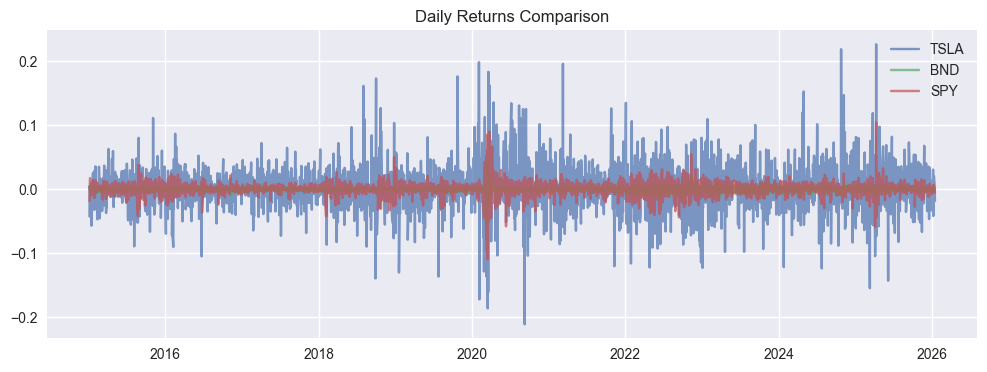

In [12]:
plt.figure(figsize=(12, 4))

plt.plot(returns["TSLA"], label="TSLA", alpha=0.7)
plt.plot(returns["BND"], label="BND", alpha=0.7)
plt.plot(returns["SPY"], label="SPY", alpha=0.7)

plt.title("Daily Returns Comparison")
plt.legend()
plt.show()


## Rolling Volatility Analysis

Rolling volatility measures how risk changes over time.
A 30-day rolling window is commonly used in financial analysis.


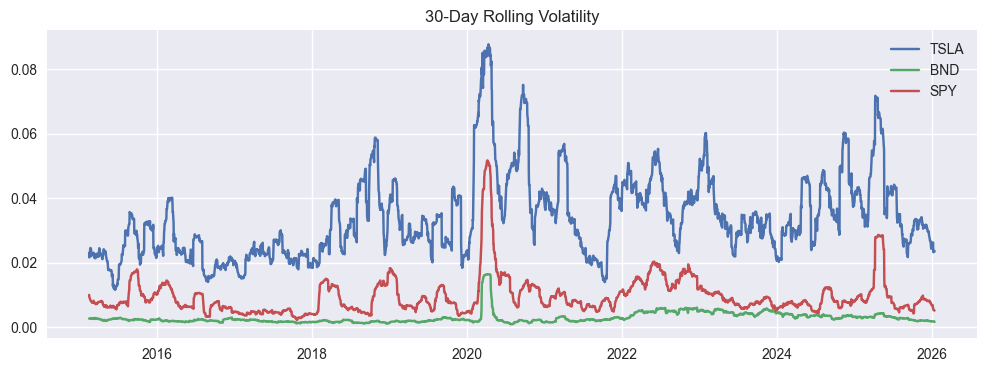

In [13]:
rolling_vol = returns.rolling(window=30).std()

plt.figure(figsize=(12, 4))
plt.plot(rolling_vol["TSLA"], label="TSLA")
plt.plot(rolling_vol["BND"], label="BND")
plt.plot(rolling_vol["SPY"], label="SPY")

plt.title("30-Day Rolling Volatility")
plt.legend()
plt.show()


## Stationarity Testing Using Augmented Dickey-Fuller Test

Time series models such as ARIMA require stationary data.
The ADF test helps determine whether a series is stationary.


In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    result = adfuller(series)
    print(f"ADF Test for {name}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("-" * 40)

adf_test(prices["TSLA"], "TSLA Price")
adf_test(returns["TSLA"], "TSLA Returns")


ADF Test for TSLA Price
ADF Statistic: -0.7801569882105652
p-value: 0.8248814297221106
----------------------------------------
ADF Test for TSLA Returns
ADF Statistic: -53.0196185442436
p-value: 0.0
----------------------------------------


## Value at Risk (VaR)

Value at Risk (VaR) estimates the maximum expected loss over a given time period
at a specified confidence level. In this analysis, we compute the 95% daily VaR.


### ADF Test Interpretation

**Augmented Dickey-Fuller (ADF) Test Results:**

The ADF test evaluates whether a time series is stationary (mean and variance are constant over time). 

- **For TSLA Prices**: The ADF statistic of -0.78 with p-value of 0.82 indicates the price series is **non-stationary**. This is expected for stock prices, which typically exhibit trends and changing volatility over time.

- **For TSLA Returns**: The ADF statistic of -53.02 with p-value of 0.0 indicates the returns series is **stationary**. This is crucial for time series modeling (e.g., ARIMA), as stationary data is required for reliable forecasting.

**Implication**: We should use returns (not prices) for time series modeling, as they satisfy the stationarity assumption.

### Value at Risk (VaR) Interpretation

**95% Daily VaR Results:**

Value at Risk (VaR) represents the maximum expected loss at a 95% confidence level over a single trading day.

- **TSLA**: VaR of -5.25% means we expect that on 95% of trading days, losses will not exceed 5.25% of the investment value. This reflects TSLA's high volatility as a growth stock.

- **BND**: VaR of -0.48% indicates very low risk, consistent with bonds being a conservative investment. On 95% of days, losses should not exceed 0.48%.

- **SPY**: VaR of -1.67% represents moderate risk, typical for a broad market index. This is higher than bonds but lower than individual high-growth stocks.

**Implication**: These VaR values help inform portfolio allocation decisions, allowing investors to understand potential downside risk for each asset.

### Sharpe Ratio Interpretation

**Daily Sharpe Ratio Results:**

The Sharpe Ratio measures risk-adjusted returns by comparing excess returns to volatility. Higher values indicate better return per unit of risk.

- **TSLA**: Sharpe ratio of 0.052 suggests moderate risk-adjusted performance. While TSLA has high returns, its high volatility reduces the risk-adjusted metric.

- **BND**: Sharpe ratio of 0.024 is the lowest, reflecting bonds' low returns relative to their (still low) volatility. This is typical for conservative fixed-income assets.

- **SPY**: Sharpe ratio of 0.051 is similar to TSLA, indicating good risk-adjusted returns for a diversified market index.

**Implication**: When comparing assets, SPY and TSLA offer similar risk-adjusted returns, but TSLA carries significantly more absolute risk. BND provides stability but lower risk-adjusted returns, making it suitable for capital preservation rather than growth.

In [15]:
# Calculate 95% Value at Risk (VaR)
VaR_95 = returns.quantile(0.05)

VaR_95


TSLA   -0.052529
BND    -0.004796
SPY    -0.016719
Name: 0.05, dtype: float64

## Sharpe Ratio

The Sharpe Ratio measures the risk-adjusted return of an asset.
Higher values indicate better return per unit of risk.


In [16]:
# Calculate daily Sharpe Ratio (risk-free rate assumed to be zero)
sharpe_ratio = returns.mean() / returns.std()

sharpe_ratio


TSLA    0.051856
BND     0.024030
SPY     0.050647
dtype: float64